Creando rutinas de preprocesamiento con Scikit-Learn
====================================================

## Introducción

TODO

## Creando una rutina de preprocesamiento en el problema censo de la UCI

Veamos como crear una rutina de preprocesamiento para el conjunto de datos del problema de censo de la UCI.

### Instalación

Necesitaremos instalar las librerias:

In [ ]:
!pip install lime eli5 --quiet

### Sobre el conjunto de datos del censo UCI

El conjunto de datos del censo de la UCI es un conjunto de datos en el que cada registro representa a una persona. Cada registro contiene 14 columnas que describen a una una sola persona, de la base de datos del censo de Estados Unidos de 1994. Esto incluye información como la edad, el estado civil y el nivel educativo. La tarea es determinar si una persona tiene un ingreso alto (definido como ganar más de $50 mil al año). Esta tarea, dado el tipo de datos que utiliza, se usa a menudo en el estudio de equidad, en parte debido a los atributos comprensibles del conjunto de datos, incluidos algunos que contienen tipos sensibles como la edad y el género, y en parte también porque comprende una tarea claramente del mundo real.

Descargamos el conjunto de datos

In [51]:
!wget https://santiagxf.blob.core.windows.net/public/datasets/uci_census.zip \
    --quiet --no-clobber
!mkdir -p datasets/uci_census
!unzip -qq uci_census.zip -d datasets/uci_census

replace datasets/uci_census/adult.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Lo importamos

In [52]:
import pandas as pd
import numpy as np

train = pd.read_csv('datasets/uci_census/data/adult-train.csv')
test = pd.read_csv('datasets/uci_census/data/adult-test.csv')

In [69]:
train

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,<=50K,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,>50K,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,<=50K,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,<=50K,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [70]:
import seaborn as sns

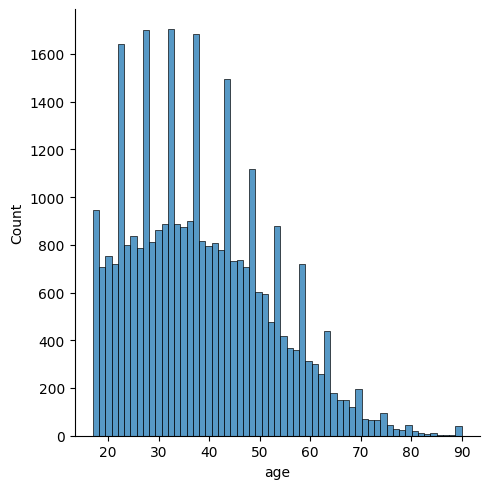

In [71]:
sns.displot(train, x="age")

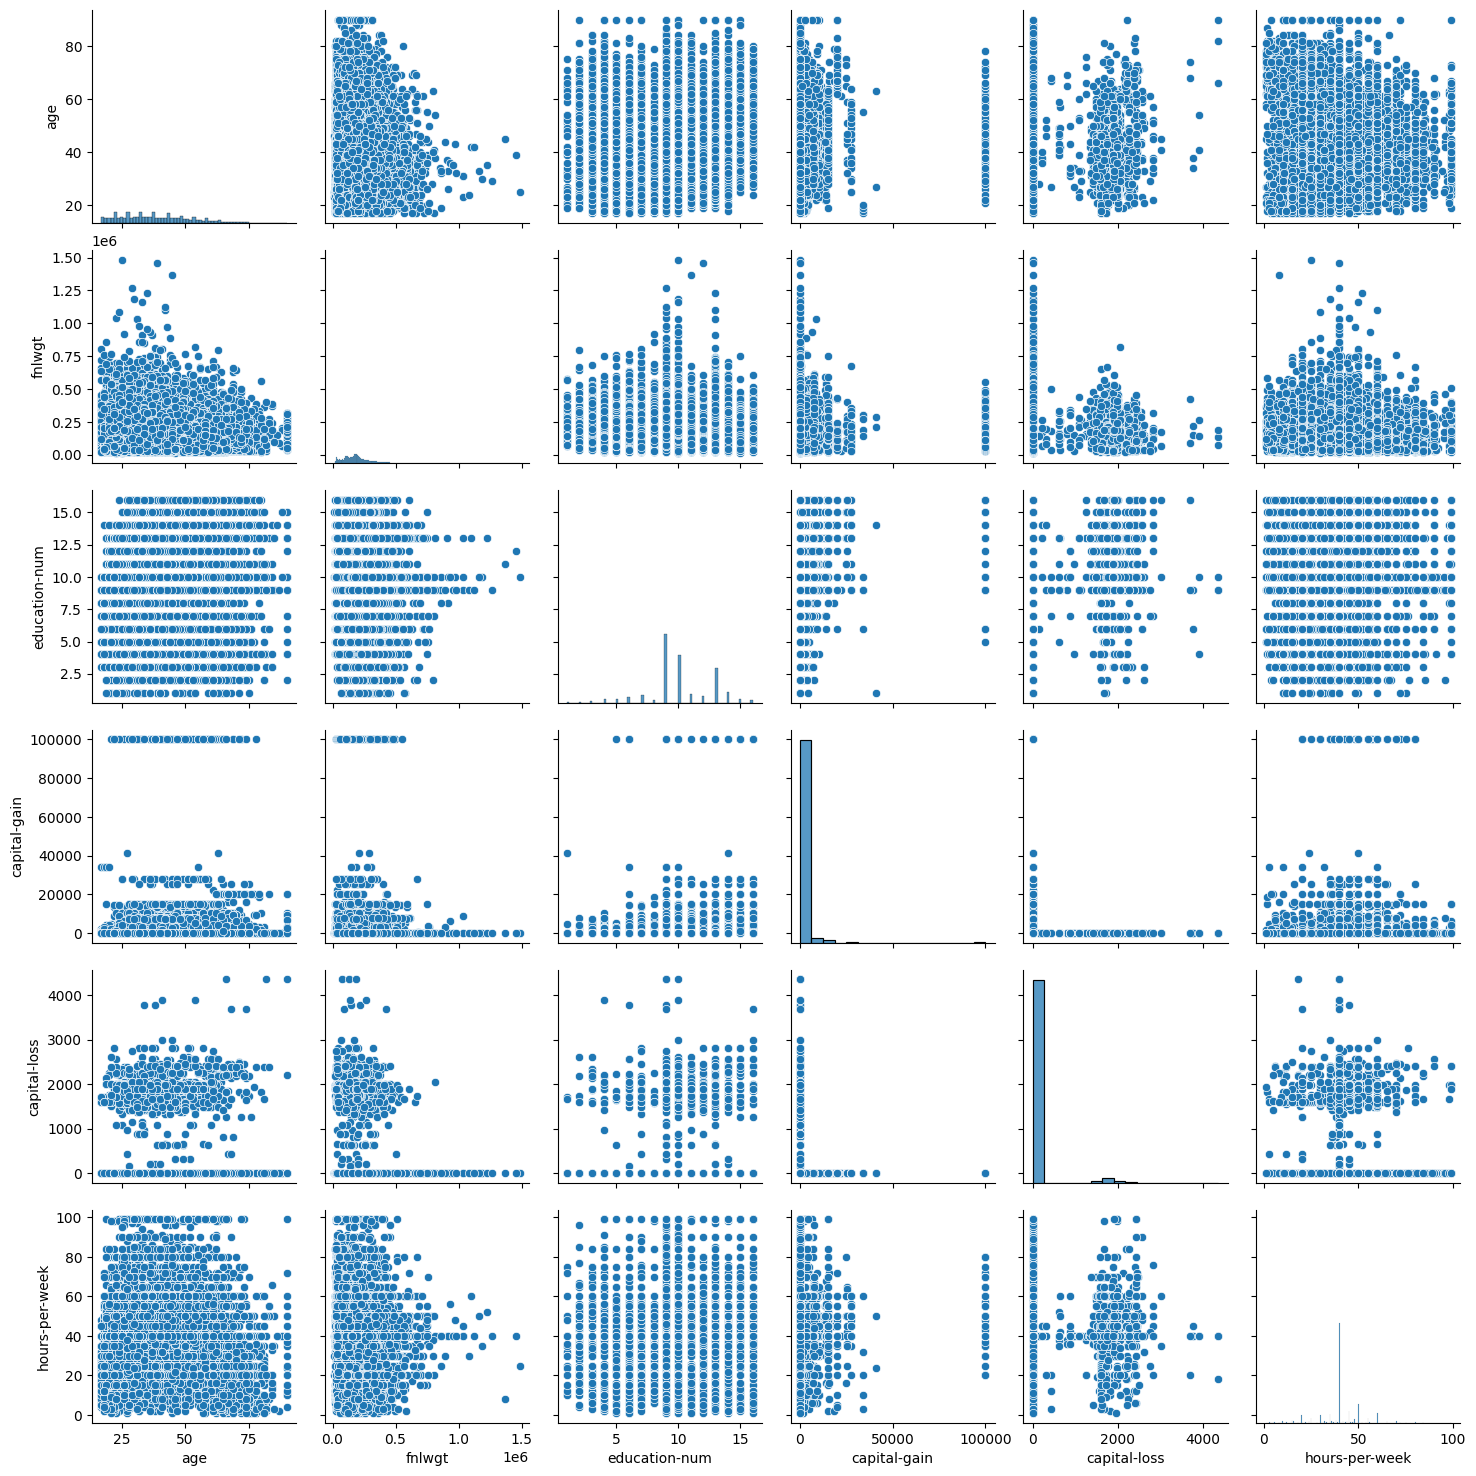

In [72]:
sns.pairplot(train)

In [68]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Generaremos 3 conjuntos de datos: entrenamiento, validación y testing.

In [53]:
from sklearn.model_selection import train_test_split

validation = test
test, _ = train_test_split(test, test_size=0.9, random_state=1234)

Separemos los predictores de la variable a predecir:

In [54]:
X_train = train.drop(['income'], axis=1)
y_train = train['income'].to_numpy()
X_test = test.drop(['income'], axis=1)
y_test = test['income'].to_numpy()
X_val = validation.drop(['income'], axis=1)
y_val = validation['income'].to_numpy()

### Preprocesando los datos

Realizaremos un pequeño preprocesamiento antes de entrenar el modelo:

- Imputaremos los valores faltantes de las caracteristicas numéricas con la media
- Imputaremos los valores faltantes de las caracteristicas categóricas con el valor `?`
- Escalaremos los valores numericos utilizando un `StandardScaler`
- Codificaremos las variables categóricas utilizando `OneHotEncoder`

Utilizaremos la siguiente rutina para ir verificando los cambios que realizamos en el conjunto de datos. La misma muestra la cantidad de muestras, la cantidad de predictores y algunos valores interesantes en el caso que indiquemos alguna columna para mostrar. Este paso no es necesario en una rutina de preprocesamiento pero simplemente nos ayuda a verificar los cambios que realizamos.

In [59]:
from typing import List, Tuple

def print_stats(df: pd.DataFrame, detail_columns: List[str] = None):
  print(f"Muestras:", df.shape[0])
  print(f"Features:", df.shape[1])

  if detail_columns:
    print('Detalles:')
    for column in detail_columns:
      print(f"\tColumna: {column}")
      if df[column].dtype in ['O', 'Object', 'int64']:
        print(f"\t\tValores únicos: {len(df[column].unique())}")
      if df[column].dtype in ['float32', 'float64']:
        print(f"\t\tMedia: {df[column].mean()}")


Por ejemplo, podemos utilizarla como sigue:

In [60]:
print_stats(train)

Muestras: 32561
Features: 15


Eliminando registros duplicados

In [62]:
train.drop_duplicates(inplace=True)

In [64]:
print_stats(train)

Muestras: 32537
Features: 15


Eliminamos valores faltantes en la columna a predecir

In [66]:
train.dropna(axis='index', subset=['income'], inplace=True)

In [67]:
print_stats(train)

Muestras: 32537
Features: 15


Reagrupando variables categoricas

In [ ]:
mapping = {
  'two': 'cuatro-o-menos',
  'three': 'cuatro-o-menos',
  'four': 'cuatro-o-menos',
  'five': 'cinco-seis',
  'six': 'cinco-seis',
  'eight': 'ocho-doce',
  'twelve': 'ocho-doce',
}

In [ ]:
Reagrupando variables categoricas

In [56]:
from sklearn.compose import TransformerMixin, _BaseComposition

class PreprocessUCI(TransformerMixin, _BaseComposition):
    def transform(self, X):
        """Transform X separately by each transformer, concatenate results.

        Parameters
        ----------
        X : {array-like, dataframe} of shape (n_samples, n_features)
            The data to be transformed by subset.

        Returns
        -------
        X_t : {array-like, sparse matrix} of \
                shape (n_samples, sum_n_components)
            Horizontally stacked results of transformers. sum_n_components is the
            sum of n_components (output dimension) over transformers. If
            any result is a sparse matrix, everything will be converted to
            sparse matrices.
        """

sklearn.compose._column_transformer.make_column_selector

In [58]:
from typing import Tuple, List

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def prepare(X: pd.DataFrame, transformations: sklearn.compose.ColumnTransformer = None) -> Tuple[pd.DataFrame, sklearn.compose.ColumnTransformer]:
    """
    Escala y codifica los deferentes valores de un conjunto de datos.

    Parameters
    ----------
    X: pd.DataFrame:
        Connto de datos a transformar
    transformations: sklearn.compose.ComlumnTransformer
        Transformaciones que se deben aplicar al conjunto de datos. Si no son indicadas, las mismas son aprendidas desde el conjunto de datos.

    Returns: Tuple[pd.DataFrame, sklearn.compose.ColumnTransformer]
        Una tupla donde el primer component es el conjunto de datos transformado y el segundo las transformaciones que se aplicaron.
    """
    features = {
        'discrete': X.dtypes[X.dtypes == 'object' ].index.tolist(),
        'continuous': X.dtypes[X.dtypes != 'object'].index.tolist(),
    }

    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    if transformations is None:
        transformations = ColumnTransformer(
            [
              ('continuous_pipe', num_pipe, features['continuous']),
              ('discrete_pipe', cat_pipe, features['discrete']),
            ],
            remainder='passthrough')

        X = transformations.fit_transform(X)
    else:
        X = transformations.transform(X)

    transformed_discrete_features = transformations.transformers_[1][1].named_steps['encoder'].get_feature_names_out(features['discrete'])
    all_features = features['continuous'] + list(transformed_discrete_features)

    return pd.DataFrame(X, columns=all_features), transformations


X_train_transformed, transformations = prepare(X_train)
X_test_transformed, _ = prepare(X_test, transformations)

Entrenamos un modelo basado en `lightgbm`

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=1)
model = clf.fit(X_train_transformed, y_train)

### Computando los valores de LIME

Computemos algunos datos que serán útiles luego:

* `classes` contiene los nombres de las clases que vamos a predecir
* `features` contiene el nombre de todas las columnas del conjunto de datos.
* `categorical_features` contiene un dictionario que tiene como índice

In [ ]:
classes = train['income'].unique().tolist()
features = X_train_transformed.columns.values.tolist()
categorical_features = {idx: X_train_transformed.columns[idx] for idx, col in enumerate(X_train_transformed.dtypes) if col == object}

Utilizando la librería LIME crearemos un `LimeTabularExplainer`. Vea como configuramos cada una de las propiedades:

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
		training_data=X_train_transformed.values,
		training_labels=y_train,
    feature_names = features,
    categorical_features = categorical_features.keys(),
    categorical_names = categorical_features.values,
    class_names=classes,
		mode='classification')

Una vez que tenemos el explicador creado, simplemente podemos elegir cualquiera de las instancias de datos que queremos explicar para computar el modelo lineal de LIME:

In [ ]:
observation_to_explain = 16
data_row = X_test_transformed.iloc[observation_to_explain].values

Utilizando esta instancia de datos, utilizaremos el método `explain_instance`:

In [ ]:
exp = explainer.explain_instance(
	data_row = data_row,
	predict_fn = model.predict_proba)

Una forma práctica de explorar los resultados es utilizando el método `show_in_notebook()` el cual muestra un diagrama de fuezas para cada una de las clases que nuestro modelo predice:

In [ ]:
exp.show_in_notebook()

#### Cómo interpretar los números

Si una característica tiene un coeficiente particularmente grande en el modelo lineal, significaría que la eliminación de esa característica cambia drásticamente la entrada. En la tabla y el gráfico se puede ver qué características contribuye a clasificar la observación a cada una de las clases. Recuerda que en este caso 0 representa tiempo presente y 1 representa tiempo pasado.